In [34]:
def create_data(image_dir):
    """Gets numpy data from images that are in the folders."""

    image_files = [image_dir + '{0}'.format(f)
                           for f in os.listdir(image_dir) if not f.startswith('.')]


    num_images = len(image_files)
    images_np_arr = np.empty([num_images, 256, 256, 1], dtype=np.float32)


    for image in range(num_images):
        img = cv2.imread(image_files[image])
        img = cv2.resize(img,(256,256))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        img = img.reshape(256, 256, 1)
        img = img.astype(np.float32)
        images_np_arr[image] = img

    data = images_np_arr

 
    return data


In [43]:
import tensorflow as tf
import os
import numpy as np
import cv2
 
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Activation, Conv2D, BatchNormalization, Subtract
from tensorflow.python.keras.initializers import normal
from matplotlib import pyplot as plt

print(tf.__version__)

#get current working directory
cwd = os.getcwd()

train_data = create_data(cwd+"/data/dataset/image_patch/Train/")
test_data = create_data(cwd+"/data/dataset/image_patch/Test/")

train_data_noise = create_data(cwd+"/data/dataset/image_patch_noise/Train/")
test_data_noise = create_data(cwd+"/data/dataset/image_patch_noise/Test/")

# print(train_data[0])

def denoise_model(image):
    """Model that denoises the noisy image."""
    
    initializer = normal(mean=0, stddev=0.01, seed=13)

    x = Conv2D(64, (3, 3), padding='same', kernel_initializer=initializer)(image)

    bn1 = BatchNormalization()(x)

    act1 = Activation(activation='selu')(bn1)

    x = Conv2D(64, (3, 3), padding='same', kernel_initializer=initializer)(act1)

    bn1 = BatchNormalization()(x)

    act1 = Activation(activation='selu')(bn1)

    encoded = Conv2D(32, (3, 3), padding='same', kernel_initializer=initializer)(act1)

    bn1 = BatchNormalization()(encoded)

    act1 = Activation(activation='selu')(bn1)


    x = Conv2D(32, (3, 3),padding='same', kernel_initializer=initializer)(act1)

    bn1 = BatchNormalization()(x)

    act1 = Activation(activation='selu')(bn1)

    x = Conv2D(64, (3, 3), padding='same', kernel_initializer=initializer)(act1)

    bn1 = BatchNormalization()(x)

    act1 = Activation(activation='selu')(bn1)

    x = Conv2D(64, (3, 3), padding='same', kernel_initializer=initializer)(act1)

    bn1 = BatchNormalization()(x)

    act1 = Activation(activation='selu')(bn1)

    decoded = Conv2D(1, (3, 3), padding='same', kernel_initializer=initializer)(act1)

    decoded = Subtract()([image, decoded])
    
    return decoded 

input_img = Input(shape=(256,256,1)) 

output = denoise_model(input_img)

autoencoder = Model(input_img, output)

# autoencoder.load_weights(cwd+"/model_new.h5")

autoencoder.compile(optimizer='Adam', loss='mse')

autoencoder.fit(train_data_noise, train_data,
                epochs=10,
                batch_size=8,
                shuffle=True,
                validation_data=(test_data_noise, test_data))

autoencoder.save(cwd+"/model_new.h5")


test_data_denoised = autoencoder.predict(test_data_noise)


2.1.0
Train on 200 samples, validate on 100 samples
Epoch 1/10
200/200 [==============================] - 11s 53ms/sample - loss: 165.9069 - val_loss: 194.9730
Epoch 2/10
200/200 [==============================] - 10s 48ms/sample - loss: 125.2887 - val_loss: 186.4492
Epoch 3/10
200/200 [==============================] - 9s 47ms/sample - loss: 112.1492 - val_loss: 182.2196
Epoch 4/10
200/200 [==============================] - 9s 47ms/sample - loss: 109.0970 - val_loss: 136.5659
Epoch 5/10
200/200 [==============================] - 10s 48ms/sample - loss: 105.4361 - val_loss: 173.0398
Epoch 6/10
200/200 [==============================] - 10s 48ms/sample - loss: 105.3252 - val_loss: 126.4546
Epoch 7/10
200/200 [==============================] - 10s 48ms/sample - loss: 105.4593 - val_loss: 118.9419
Epoch 8/10
200/200 [==============================] - 10s 48ms/sample - loss: 105.0469 - val_loss: 136.4735
Epoch 9/10
200/200 [==============================] - 10s 48ms/sample - loss: 103.8759

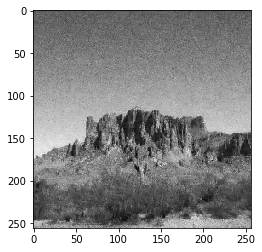

In [44]:
#Denoised Image
plt.imshow(test_data_denoised[5].reshape(256,256), cmap='gray')

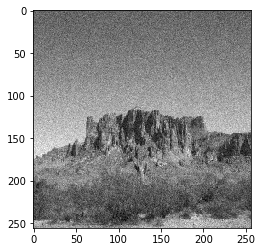

In [37]:
#Noisy Image
plt.imshow(test_data_noise[5].reshape(256,256), cmap='gray')